# Linear Models

- [Problem Definition](#problem-definition)
- [Target Function](#target-function)
- [Raw Data](#raw-data)
- [Preprocessing](#preprocessing)
- [Machine Learning](#machine-learning)
    - [Training](#training)
    - [Model](#model)
- [Stochasic Gradient Descent](#stochastic-gradient-descent)
    - [`NumPy`](#sgd-numpy)
    - [`scikit-learn`](#sgd-sklearn)
    - [`TensorFlow`](#sgd-tf)
    - [`Keras`](#sgd-keras)
- [Maximum Likelihood Estimator](#maximum-likelihood-estimator)
    - [`NumPy`](#mle-numpy)
    - [`scikit-learn`](#mle-sklearn)
- [Challenge](#challenge)

## Problem Definition <a class="anchor" id="problem-definition"></a>

Given some dataset $S = \{ (x_{i}, y_{i}): x_i \in \mathcal{X} \text{, } y_i \in \mathcal{Y} \text{, } 0 < i \leq K \}$, where:<br>
* $\mathcal{X}$: the Input Space, such that: $\mathcal{X} \subset \mathbb{R}^{n}$
* $\mathcal{Y}$: the Output Space, such that: $\mathcal{X} \subset \mathbb{R}^{m}$

find the **optimal** linear<a href="#linearref" id="linear"><sup>[1]</sup></a> function $f$, such that:
$$f: \mathcal{X} \rightarrow \mathcal{Y} \text{,} \\ f(x_{i}) := y_{i} \text{, } \forall i$$

An example of the $k^{th}$ datapoint for $n=2$ and $m=1$ is:
$$ x_{k} = \begin{bmatrix}
               x_{k}^{(1)} & x_{k}^{(2)}
           \end{bmatrix}^{T}
         = \begin{bmatrix}
               1 & 2
           \end{bmatrix}^{T}
\text{,} \quad
   y_{k} = \begin{bmatrix}
               y_{k}^{(1)}
           \end{bmatrix}
         = \begin{bmatrix}
               3
           \end{bmatrix}
$$

### Formalisation
Since $f$ is linear, for every datapoint $i$, it can be expressed as:
$$f(x_{i}) := y_{i} = w^{(0)} + x_{i}^{(1)}w^{(1)} + x_{i}^{(2)}w^{(2)} + \text{...} + x_{i}^{(n)}w^{(n)}  \text{, } \forall i$$
where:<br>
* $w$: the Weigths Vector, such that: $w \in \mathbb{R}^{n \times m}$

Rewritten in matrix format:
$$f(X) := y = X * w$$
where,<br>
* $X = \begin{bmatrix} x_{1}^{T} & x_{2}^{T} & \text{...} \end{bmatrix}^{T} $: a (long) matrix, formatted by stacking the input datapoints $x_{i}$, such that $X \in \mathbb{R}^{K \times n}$
* $y = \begin{bmatrix} y_{1}^{T} & y_{2}^{T} & \text{...} \end{bmatrix}^{T} $: a (long) matrix, formatted by stacking the output datapoints $y_{i}$, such that $y \in \mathbb{R}^{K \times m}$

### Example
Assume we are given the price for a **market index $J$** $benchmark(t)$ and the price of **stock $A$** $stock(t)$.<br>
We are interested in developing a linear model that relates $J$ price, $benchmark$, with $A$price, $stock(t+1)$, such that:

$$stock = \beta * benchmark + \alpha$$

A sample of the dataset $S$ is visualized below:

| benchmark  | stock |
| ---------- | ----- |
| 5.0        | 1.6   |
| 1.0        | 0.6   |
| 3.7        | 1.3   |
| 9.8        | 2.3   |
| 2.8        | 0.8   |

<a id="linearref" href="#linear"><sup>[1]</sup></a> linear with regard to inputs $x_{i}$

In [1]:
# scientific computing library
import numpy as np
# machine learning library
import sklearn
# deep learning framework
import tensorflow as tf

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# show plots without need of calling `.show()`
%matplotlib inline

# prettify plots
plt.rcParams['figure.figsize'] = [20.0, 5.0]
sns.set_palette(sns.color_palette("muted"))
sns.set_style("ticks")

# supress warnings
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
def visualize(x, y=None, y_noise=None, y_hat=None):
    """Visualization helper function.
    
    Parameters
    ----------
    x: array-like
        x-axis values
    y: array-like
        y-axis target values
    y_noise: array-like
        y-axis observations
    y_hat: array-like
        y-axis model predictions
    """
    if y is not None:
        plt.plot(x, y, label='Target Function')
    if y_noise is not None:
        plt.plot(x, y_noise, 'o', label='Noisy Observations')
    if y_hat is not None:
        plt.plot(x, y_hat, '--o', label='Model Predictions')
    plt.legend();

## Target Function <a class="anchor" id="target-function"></a>

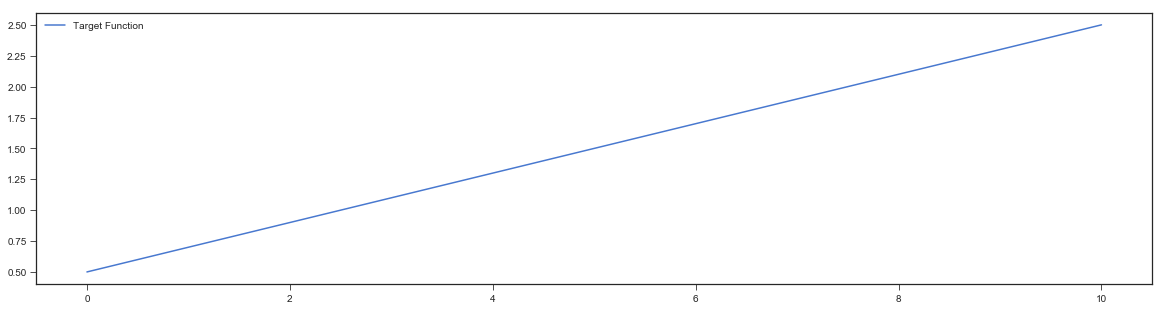

In [3]:
N = 10
np.random.seed(0)

x = np.linspace(0, N, N)
y = 0.5 + 0.2 * x
visualize(x, y);

## Raw Data <a class="anchor" id="raw-data"></a>

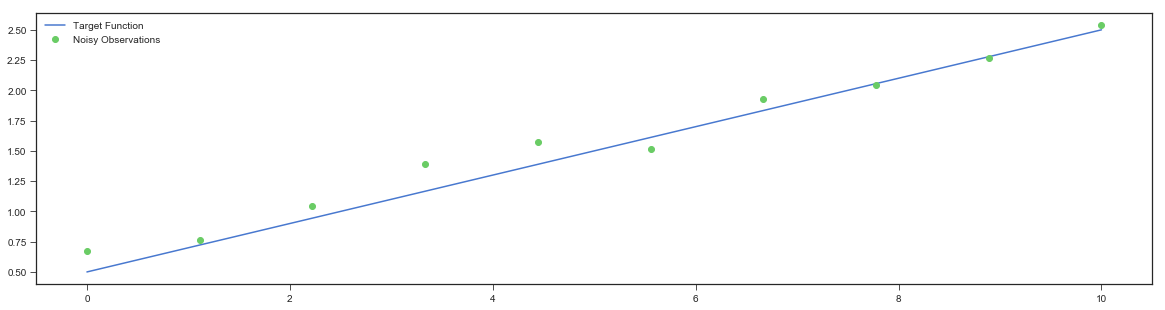

In [4]:
y_noise = y + np.random.normal(0,0.1, N)

visualize(x, y, y_noise)

## Preprocessing <a class="anchor" id="preprocessing"></a>

In [5]:
X = np.ones((N, 2))
X[:, 1 ] = x

## Machine Learning <a class="anchor" id="machine-learning"></a>

Machine learning is the science of getting computers to act without being explicitly programmed.
Their course of action highly depends on the data that has been used in order to **train** them, while the generated program (a.k.a **model**) is a function of the data and the algorithm used to consume this data.

### Training <a class="anchor" id="training"></a>

Training is nothing more than the process of optimizating:
$$\mathcal{J}(w) = \min_{w}\bigg[ \mathbb{E} \big[ \mathcal{L}(\mathbf{y}, f(\mathbf{X} | w)) \big] + \lambda \mathcal{R}(w) \bigg]$$

where,
* $\mathcal{J}$: Objective Function
* $\mathcal{L}$: Loss Function
* $\mathcal{R}$: Regularization Term
* $f$: Mapping Function (`model`)
* $w$: `model` Parameters
* $S = \{ (x_{i}, y_{i}): i \in \mathcal{D} \}$

Assumming that $\mathcal{J}$ has a (global) minimum, such that:

$\DeclareMathOperator*{\argmin}{arg\,min}$
$$w^{*} = \argmin_{w}\bigg[ \mathbb{E} \big[ \mathcal{L}(\mathbf{y}, f(\mathbf{X} | w)) \big] + \lambda \mathcal{R}(w) \bigg]$$

where,
* $w^{*}$: Objective Function (Global) Minimizer

### Model <a class="anchor" id="model"></a>

Having found $w^{*}$ the `model` $f$ can be deployed and predictions can be made according to:

$$\mathbf{\hat{y}} = f(\mathbf{X} | w^{*}) \approx \mathbf{y}$$

In the case of Linear Models, $f$ gets the form of a linear function, with $w^{*}$ coefficients:

$$\mathbf{\hat{y}} = f(\mathbf{X} | w^{*}) = \mathbf{X} * w^{*} \approx \mathbf{y}$$

## Stochastic Gradient Descent <a class="anchor" id="stochastic-gradient-descent"></a>

Stochastic Gradient Descent (SGD) is the simplest and most used 


$$
\begin{aligned}
    \hat{y} &= X*w \\
    \mathcal{L}(w) &= \frac{1}{2} \sum_{i=1}^{n}(y_{i} - f(x_{i} | w))^{2} \\
    \\
    w_{t+1} &= w_{t} - \eta \nabla_{w} \mathcal{L}(w) \\
    w_{t+1} &= w_{t} - \eta (y_{i} - f(x_{i} | w)) x_{i}
\end{aligned}$$

### `NumPy` <a class="anchor" id="sgd-numpy"></a>

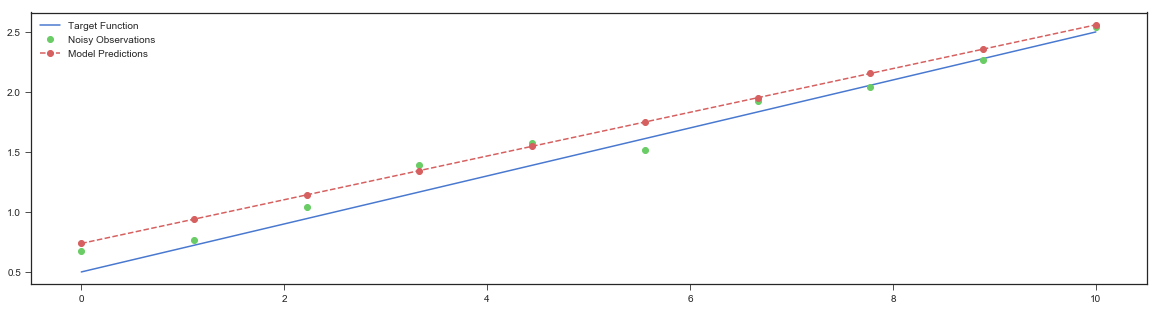

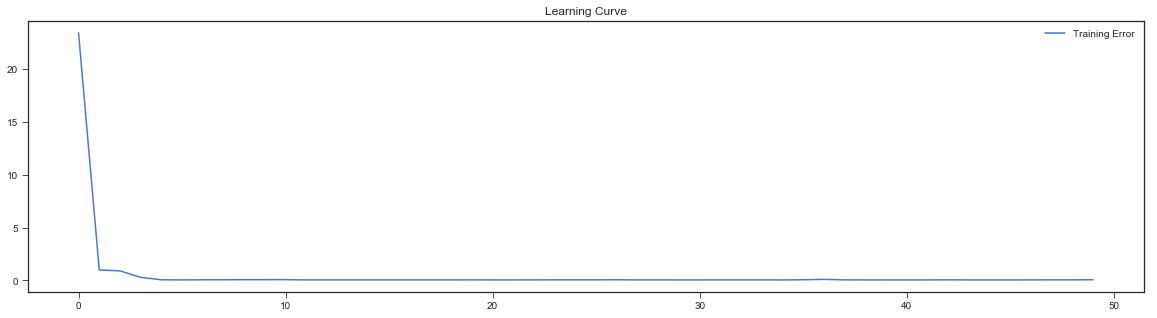

In [6]:
# hyperparameters
n_epochs = 50
eta = 0.01

# parameters initialization
w = np.random.random(X.shape[1])

# training error over time
loss = []

# model fitting
for _ in range(n_epochs):
    # 
    y_hat = np.dot(X, w)
    l = 0.5 * np.sum((y_noise - y_hat)**2)
    i = np.random.randint(len(y_noise))
    error = y_hat[i] - y_noise[i]
    w = w - eta * error * X[i]
    loss.append(l)

# plot results
visualize(x, y, y_noise, y_hat)

# plot training error
plt.figure()
plt.plot(loss)
plt.title('Learning Curve')
plt.legend(['Training Error']);

### `scikit-learn`  <a class="anchor" id="sgd-sklearn"></a>

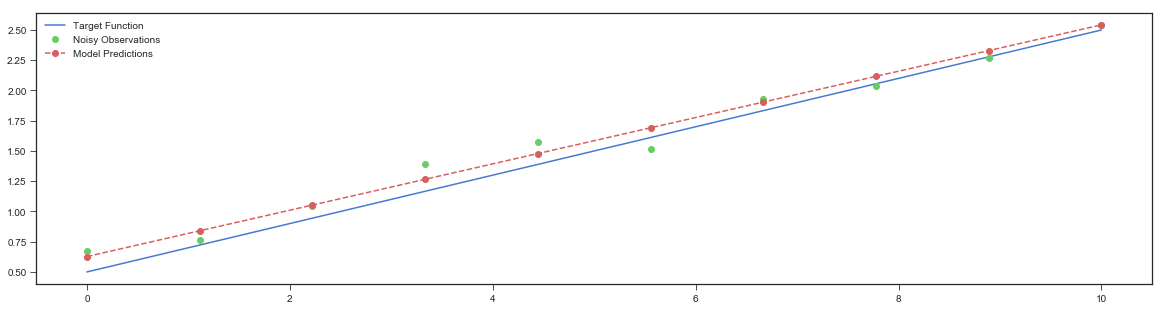

In [7]:
from sklearn.linear_model import SGDRegressor

# hyperparameters
n_epochs = 100
eta = 0.01

# model initialization
model = SGDRegressor(loss='squared_loss', penalty='none', max_iter=n_epochs, learning_rate='constant', eta0=eta)

# model fitting & predictions
model.fit(X, y_noise)
y_hat = model.predict(X).ravel()

# plot results
visualize(x, y, y_noise, y_hat)

### `TensorFlow` <a class="anchor" id="sgd-tf"></a>

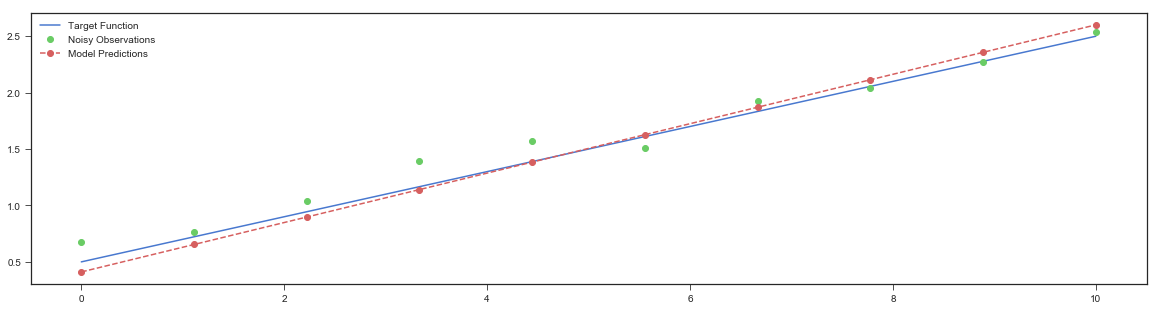

In [8]:
# hyperparameters
n_epochs = 100
eta = 0.01

# placeholders
X_tf = tf.placeholder(tf.float64, shape=[None, X.shape[1]])
Y_tf = tf.placeholder(tf.float64, shape=[None])

# variables
W_tf = tf.Variable(np.random.random(X.shape[1]).reshape(X.shape[1], 1), name='parameters')

# model prediction
y_hat = tf.matmul(X_tf, W_tf)

# optimization
loss = tf.reduce_mean(tf.square(tf.squeeze(y_hat)-Y_tf)) # L2 loss
optimizer = tf.train.GradientDescentOptimizer(eta).minimize(loss) # Gradient descent

# initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    # model fitting
    for _ in range(n_epochs):
        sess.run(optimizer, feed_dict={X_tf: X, Y_tf: y_noise})
    
    # model predictions
    y_hat = sess.run(y_hat, feed_dict={X_tf: X, Y_tf: y_noise})
    
    # plot results
    visualize(x, y, y_noise, y_hat)

### `Keras` <a class="anchor" id="sgd-keras"></a>

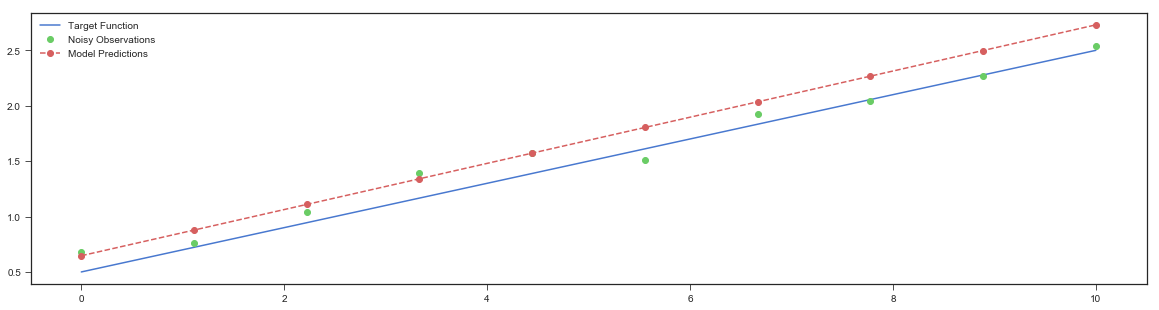

In [9]:
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Dense

# hyperparameters
n_epochs = 100
eta = 0.01


# model initialization
model = Sequential()
model.add(Dense(1, input_shape=(1, 1), activation='linear'))
model.compile(loss='mean_squared_error', optimizer='sgd')

# keras batch training interface
X_ = x.reshape(len(x), 1, 1)
y_ = y_noise.reshape(len(y_noise), 1, 1)

# model fitting & predictions
model.fit(X_, y_, batch_size=1, epochs=n_epochs, verbose=0)
y_hat = model.predict(X_).ravel()

# plot results
visualize(x, y, y_noise, y_hat)

## Maximum Likelihood Estimator  <a class="anchor" id="maximum-likelihood-estimator"></a>

### `NumPy` <a class="anchor" id="mle-numpy"></a>

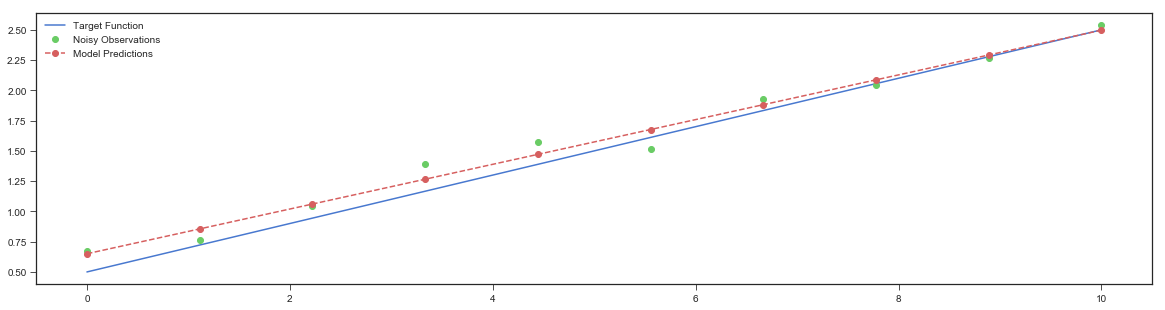

In [10]:
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_noise)
y_hat = np.dot(X, w)

visualize(x, y, y_noise, y_hat)

### `scikit-learn` <a class="anchor" id="mle-sklearn"></a>

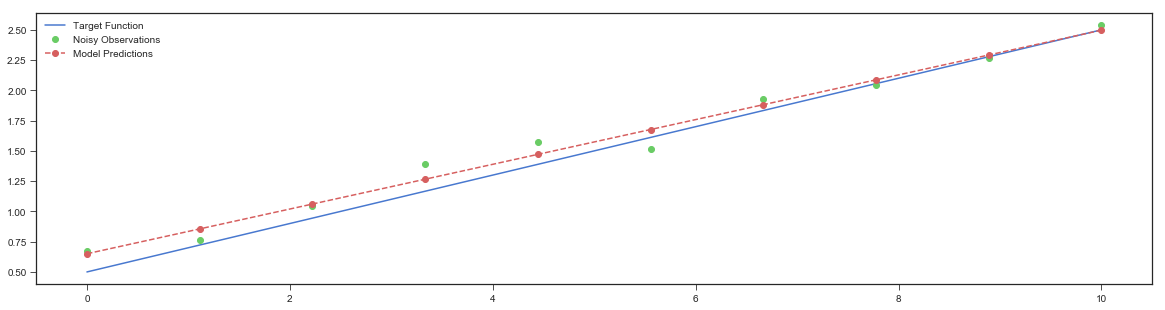

In [11]:
from sklearn.linear_model import LinearRegression

# model initialization
model = LinearRegression()

# model fitting & predictions
model.fit(X, y_noise)
y_hat = model.predict(X).ravel()

# plot results
visualize(x, y, y_noise, y_hat)

## Challenges <a class="anchor" id="challenge"></a>

### Beta Hedging <a class="anchor" id="beta-hedging"></a>

Repeat the above experiment using the implementation you prefer most, on real world market data.<br>
Using the data provided in `{proj_dir}/notebooks/data/`:
* **S&P500 (SPY)**: as the market index (benchmark)
* **Apple (AAPL)**: as stock A
* **Google (GOOG)** as stocks B<br>

come up with a <u>Beta Hedging Strategy</u> to minimize risk.<br><br>

Load the data to a numpy.ndarray using the commands below:

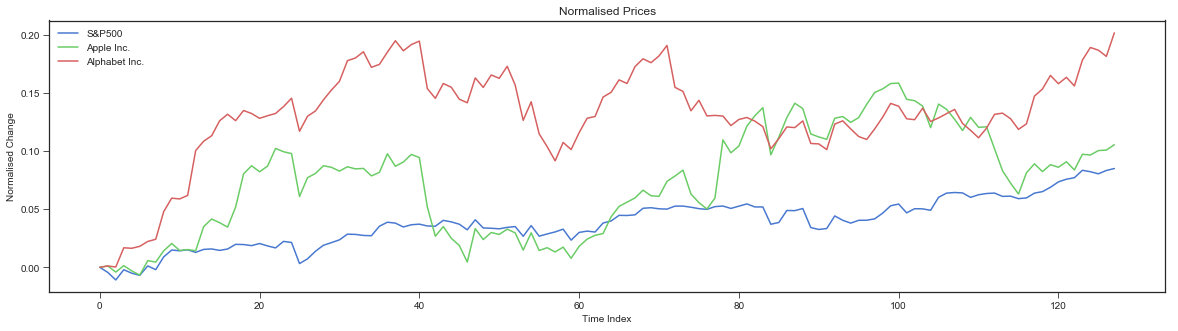

In [12]:
# helper loader function
loader = lambda asset: np.loadtxt('./data/%s.txt' % asset, delimiter=',')

# raw data
spy = loader('SPY')
aapl = loader('AAPL')
goog = loader('GOOG')

# normalised data
spy_ = spy / spy[0] - 1
aapl_ = aapl / aapl[0] - 1
goog_ = goog / goog[0] - 1

# visualization
plt.plot(spy_, label='S&P500')
plt.plot(aapl_, label='Apple Inc.')
plt.plot(goog_, label='Alphabet Inc.')
plt.title('Normalised Prices')
plt.ylabel('Normalised Change')
plt.xlabel('Time Index')
plt.legend();

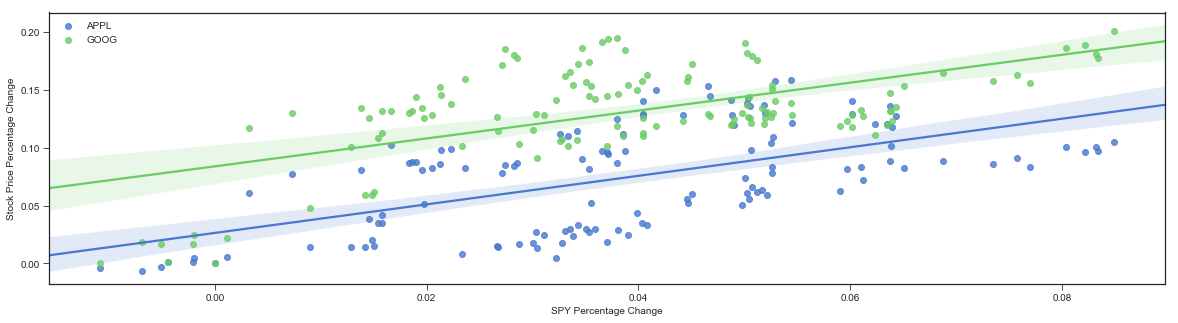

In [13]:
# regression plots
sns.regplot(spy_, aapl_, label='APPL')
sns.regplot(spy_, goog_, label='GOOG')
plt.xlabel('SPY Percentage Change')
plt.ylabel('Stock Price Percentage Change')
plt.legend();

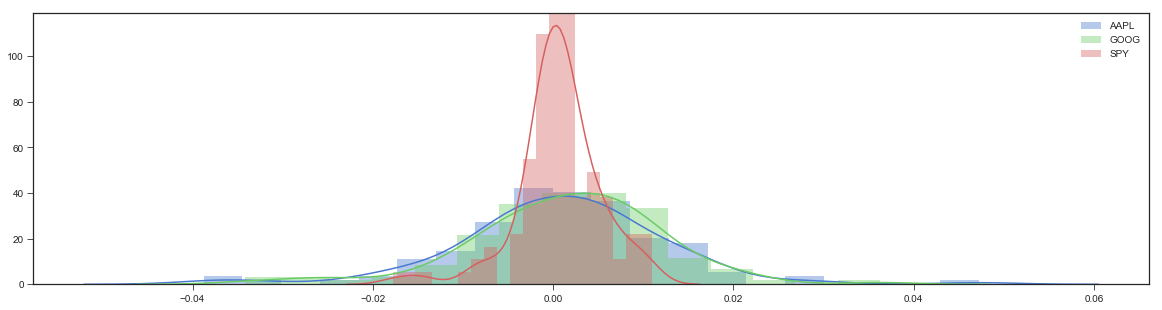

In [14]:
# helper percentage return
pct_change = lambda series: np.diff(series) / (series[:-1] + 1e-6) # WARNING: prone to division by zero

aapl_pct = pct_change(aapl)
goog_pct = pct_change(goog)
spy_pct = pct_change(spy)

sns.distplot(aapl_pct, label='AAPL')
sns.distplot(goog_pct, label='GOOG')
sns.distplot(spy_pct, label='SPY')
plt.legend();

## Generic API <a class="anchor" id="generic-api"></a>